# Code for training CNNs, as detailed in Gregory et al., 2023

This work involves learning state-dependent sea ice model error in the GFDL SPEAR model, by training Convolutional Neural Networks (CNNs) to predict sea ice concentration data assimilation increments from a JRA-forced ice-ocean SPEAR data assimilation run (see Zhang et al., 2020). In this notebook we show how the data preprocessing was performed to generate the inputs for each network (see image below). We also show how the cross-validation tests were performed during network training, and subsequently some plots of the predictions and error metrics

In [ ]:
import os
import numpy as np
import xarray as xr
import collections
from NNetwork import *
from preprocessing import pad
from IPython.display import Image,display

### DOWNLOAD TRAINING DATA (approx 45GB total) ###
if os.path.exists('seaice_DA-ML_inputs_1982-2017.nc')==False:
    os.system('wget -nv ftp://sftp.gfdl.noaa.gov/perm/William.Gregory/seaice_DA-ML_inputs_1982-2017.nc')
if os.path.exists('seaice_DA-ML_outputs_1982-2017.nc')==False:
    os.system('wget -nv ftp://sftp.gfdl.noaa.gov/perm/William.Gregory/seaice_DA-ML_outputs_1982-2017.nc')

grid = xr.open_dataset('../data_files/ice.static.nc')
lon = grid.GEOLON.to_numpy()
lat = grid.GEOLAT.to_numpy()
display(Image(open('../figures/networks.png','rb').read()))

### Load increments

dSICN corresponds to the subgrid ice thickness distribution category sea ice concentration increments from the data assimilation experiment. The sum of these subgrid terms equals the aggregate sea ice concentration increments

In [2]:
increments = xr.open_dataset('seaice_DA-ML_outputs_1982-2017.nc')

# Network A

### Load and pre-process input variables

We are training the networks on the forecast states and tendencies (time-derivative of the states) from the data assimilation experiment. Here we read the pre-computed 5-day means (assimilation is performed at 5-day frequency), of the states and tendencies

In [5]:
pad_size = 4 #size of padding each side of the inputs

inputs = ['SIC','SST','SIU','SIV','SIT','SW','TS','SSS']
forecasts = xr.open_dataset('seaice_DA-ML_inputs_1982-2017.nc')

X = []
for label in inputs:
    X.append(pad(forecasts[label].isel(n=0).to_numpy(),label,pad_size))
    X.append(pad(forecasts[label].isel(n=1).to_numpy(),label,pad_size))
X = np.transpose(X,(1,0,2,3))

land_mask = np.copy(X[:,0])
land_mask[~np.isnan(land_mask)] = 1
land_mask[np.isnan(land_mask)] = 0
land_mask[:,:4] = 0

X = np.hstack((X,land_mask[:,None]))

### Split train/test data, standardize inputs, and generate predictions

In the paper, we performed model selection by doing 5-fold cross-validation. Normalizing the inputs for each CV experiment was performed by computing mean and standard deviation statistics over ocean grid cells above 40 degrees latitude, across all training samples

In [4]:
def LossA(outputs, targets):
    return torch.mean((outputs-targets)**2)

argsA = {
'kernel_size':3,
'zero_padding':0,
'h_channels':[32,64,128],
'stride':1,
'epochs':150,
'lr':0.001,
'loss':LossA,
'batch_size':10,
'wd':1e-7,
'bias':False,
'seed':711,
}

#splitting data for 5-fold cross-validation
kfold = int(len(X)/5)
test_fracs = [np.arange(kfold*i,kfold*(i+1),1) for i in range(4)]
test_fracs.append(np.arange(kfold*4,len(X),1))

predictions = []
for k in range(5):
    train = [x for x in range(len(X)) if x not in test_fracs[k]] #indices of training samples
    test = test_fracs[k] #indices of test samples

    x_train = X[train]
    x_valid = X[test]

    y_train = increments.dSIC.isel(time=train).to_numpy()
    y_valid = increments.dSIC.isel(time=test).to_numpy()

    #standardize inputs
    if os.path.exists('../data_files/NetworkA_statistics_1982-2017_CV'+str((k+1))+'.npz'):
        stats = np.load('../data_files/NetworkA_statistics_1982-2017_CV'+str((k+1))+'.npz')
        for N in range(X.shape[1]-1):
            x_train[:,N] = (x_train[:,N]-stats['mu'][N])/stats['sigma'][N]
            x_valid[:,N] = (x_valid[:,N]-stats['mu'][N])/stats['sigma'][N]

            x_train[:,N][land_mask[train]==0] = 0
            x_valid[:,N][land_mask[test]==0] = 0
    else:   
        #compute statistics over ocean grid cells above 40 degrees latitude:
        NH = np.where((lat>40) & (land_mask[0,pad_size:-pad_size,pad_size:-pad_size]==1))
        SH = np.where((lat<-40) & (land_mask[0,pad_size:-pad_size,pad_size:-pad_size]==1))
        IDs = (np.concatenate((NH[0],SH[0])),np.concatenate((NH[1],SH[1]))) 
        mu = np.zeros(X.shape[1]-1)
        sigma = np.zeros(X.shape[1]-1)
        for N in range(X.shape[1]-1):
            x_train_nopad = x_train[:,N,pad_size:-pad_size,pad_size:-pad_size]
            mu[N] = np.nanmean(x_train_nopad[:,IDs[0],IDs[1]])
            sigma[N] = np.nanstd(x_train_nopad[:,IDs[0],IDs[1]])
            x_train[:,N] = (x_train[:,N]-mu[N])/sigma[N]
            x_valid[:,N] = (x_valid[:,N]-mu[N])/sigma[N]

            x_train[:,N][land_mask[train]==0] = 0
            x_valid[:,N][land_mask[test]==0] = 0

        np.savez('../data_files/NetworkA_statistics_1982-2017_CV'+str((k+1))+'.npz',mu=mu,sigma=sigma)
    
    predictions.append(Net(x_train,y_train,x_valid,y_valid,argsA,path='../CNN_weights/NetworkA_weights_CV'+str((k+1))+'.pt'))

predictions = np.squeeze(np.vstack(predictions))

# Network B

### Load and pre-process input variables

In [37]:
X = [predictions]
for CN in range(5):
    X.append(forecasts['CN'].isel(n=0,ct=CN).to_numpy())
    X.append(forecasts['CN'].isel(n=1,ct=CN).to_numpy())
X = np.transpose(X,(1,0,2,3))

X = np.hstack((X,land_mask[:,None,pad_size:-pad_size,pad_size:-pad_size]))

### Split train/test data, standardize inputs, and generate predictions

In [24]:
def LossB(outputs,targets):
    return torch.sum(torch.mean((outputs-targets)**2,(0,2,3))) + \
                    5*torch.mean((torch.sum(outputs,1)-torch.sum(targets,1))**2)

argsB = {
'kernel_size':1,
'zero_padding':0,
'h_channels':[32,64,128],
'stride':1,
'epochs':125,
'lr':0.001,
'loss':LossB,
'batch_size':10,
'wd':1e-7,
'bias':False,
'seed':711,
}

#splitting data for 5-fold cross-validation
kfold = int(len(X)/5)
test_fracs = [np.arange(kfold*i,kfold*(i+1),1) for i in range(4)]
test_fracs.append(np.arange(kfold*4,len(X),1))

predictions = []
for k in range(5):
    #k = 2 #choose which fifth as validation chunk
    train = [x for x in range(len(X)) if x not in test_fracs[k]] #indices of training samples
    test = test_fracs[k] #indices of test samples

    x_train = X[train]
    x_valid = X[test]

    y_train = increments.dSICN.isel(time=train).to_numpy()
    y_valid = increments.dSICN.isel(time=test).to_numpy()

    #standardize inputs
    if os.path.exists('../data_files/NetworkB_statistics_1982-2017_CV'+str((k+1))+'.npz'):
        stats = np.load('../data_files/NetworkB_statistics_1982-2017_CV'+str((k+1))+'.npz')
        for N in range(X.shape[1]-1):
            x_train[:,N] = (x_train[:,N]-stats['mu'][N])/stats['sigma'][N]
            x_valid[:,N] = (x_valid[:,N]-stats['mu'][N])/stats['sigma'][N]

            x_train[:,N][land_mask[train]==0] = 0
            x_valid[:,N][land_mask[test]==0] = 0
    else:   
        #compute statistics over ocean grid cells above 40 degrees latitude:
        NH = np.where((lat>40) & (land_mask[0,pad_size:-pad_size,pad_size:-pad_size]==1))
        SH = np.where((lat<-40) & (land_mask[0,pad_size:-pad_size,pad_size:-pad_size]==1))
        IDs = (np.concatenate((NH[0],SH[0])),np.concatenate((NH[1],SH[1]))) 
        mu = np.zeros(X.shape[1]-1)
        sigma = np.zeros(X.shape[1]-1)
        for N in range(X.shape[1]-1):
            mu[N] = np.nanmean(x_train[:,N,IDs[0],IDs[1]])
            sigma[N] = np.nanstd(x_train[:,N,IDs[0],IDs[1]])
            x_train[:,N] = (x_train[:,N]-mu[N])/sigma[N]
            x_valid[:,N] = (x_valid[:,N]-mu[N])/sigma[N]

            x_train[:,N][land_mask[train,pad_size:-pad_size,pad_size:-pad_size]==0] = 0
            x_valid[:,N][land_mask[test,pad_size:-pad_size,pad_size:-pad_size]==0] = 0

        np.savez('../data_files/NetworkB_statistics_1982-2017_CV'+str((k+1))+'.npz',mu=mu,sigma=sigma)
        
    predictions.append(Net(x_train,y_train,x_valid,y_valid,argsB,path='../CNN_weights/NetworkB_weights_CV'+str((k+1))+'.pt'))

predictions = np.nansum(np.vstack(predictions),1)

# Plot predictions / Error metrics

In [24]:
#mask land 
predictions[X[:,-1]==0] = np.nan
dSIC[X[:,-1]==0] = np.nan

def l2(m):
    return np.sqrt(np.nansum(m**2,(1,2)))

def PatternCorr(m1,m2):
    return np.nansum(m1*m2,(1,2))/(l2(m1)*l2(m2))

def RMSE(m1,m2):
    return np.sqrt(np.nanmean((m1-m2)**2,(1,2)))

def get_climatology(data,f=np.nanmean):
    dates_sub = np.array([x[4:] for x in assimilation_dates])
    repeat_days = [np.where(dates_sub==item) for item, count in collections.Counter(dates_sub).items() if count > 1]
    clim = [f(data[repeat_days[ID]],0) for ID in range(len(repeat_days)-2)]
    return np.concatenate((f(data[repeat_days[-2]],0)[None],f(data[repeat_days[-1]],0)[None],clim))

def OTA(data): #analagous to 'ocean tendency adjustment' approach, e.g., Lu et al., 2020.
    dates_sub = np.array([x[4:] for x in assimilation_dates])
    clima_dates = np.roll([item for item, count in collections.Counter(dates_sub).items() if count > 1],1)
    ID_predictions = [np.where(clima_dates == x[4:])[0][0] for x in assimilation_dates]
    return get_climatology(data)[ID_predictions]

CNN_skill = [PatternCorr(predictions[:,220:],dSIC[:,220:]),PatternCorr(predictions[:,:100],dSIC[:,:100]),\
             RMSE(20*predictions[:,220:],20*dSIC[:,220:]),RMSE(20*predictions[:,:100],20*dSIC[:,:100])]

clima_prediction = OTA(dSIC)
clima_skill = [PatternCorr(clima_prediction[:,220:],dSIC[:,220:]),PatternCorr(clima_prediction[:,:100],dSIC[:,:100]),\
             RMSE(20*clima_prediction[:,220:],20*dSIC[:,220:]),RMSE(20*clima_prediction[:,:100],20*dSIC[:,:100])]

/net2/William.Gregory/miniconda/envs/m2lines/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/net2/William.Gregory/miniconda/envs/m2lines/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


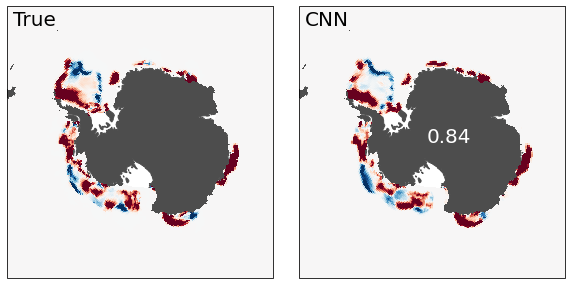

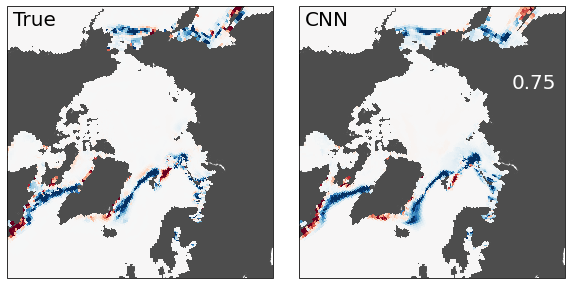

In [34]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat

day = 1383
fig,ax = plt.subplots(1,2,figsize=(10,5),subplot_kw=dict(projection=ccrs.SouthPolarStereo()))
plots = [dSIC[day],predictions[day]]
labels = ['True','CNN']
for n in range(2):
    ax[n].add_feature(cfeat.LAND,color=(0.3,0.3,0.3))
    ax[n].set_extent([-180,180,-55,-90],ccrs.PlateCarree())
    ax[n].text(0.02,0.93,labels[n],transform=ax[n].transAxes,fontsize=20)
    ax[n].pcolormesh(lon,lat,plots[n],cmap='RdBu_r',vmin=-.1,vmax=.1,transform=ccrs.PlateCarree())
ax[1].text(0.48,0.5,str(CNN_skill[1][day].round(2)),transform=ax[1].transAxes,color='white',fontsize=20)
plt.subplots_adjust(wspace=0.1)
plt.show()

day = 1675
fig,ax = plt.subplots(1,2,figsize=(10,5),subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
plots = [dSIC[day],predictions[day]]
labels = ['True','CNN']
for n in range(2):
    ax[n].add_feature(cfeat.LAND,color=(0.3,0.3,0.3))
    ax[n].set_extent([-180,180,55,90],ccrs.PlateCarree())
    ax[n].text(0.02,0.93,labels[n],transform=ax[n].transAxes,fontsize=20)
    ax[n].pcolormesh(lon,lat,plots[n],cmap='RdBu_r',vmin=-.1,vmax=.1,transform=ccrs.PlateCarree())
ax[1].text(0.8,0.7,str(CNN_skill[0][day].round(2)),transform=ax[1].transAxes,color='white',fontsize=20)
plt.subplots_adjust(wspace=0.1)
plt.show()

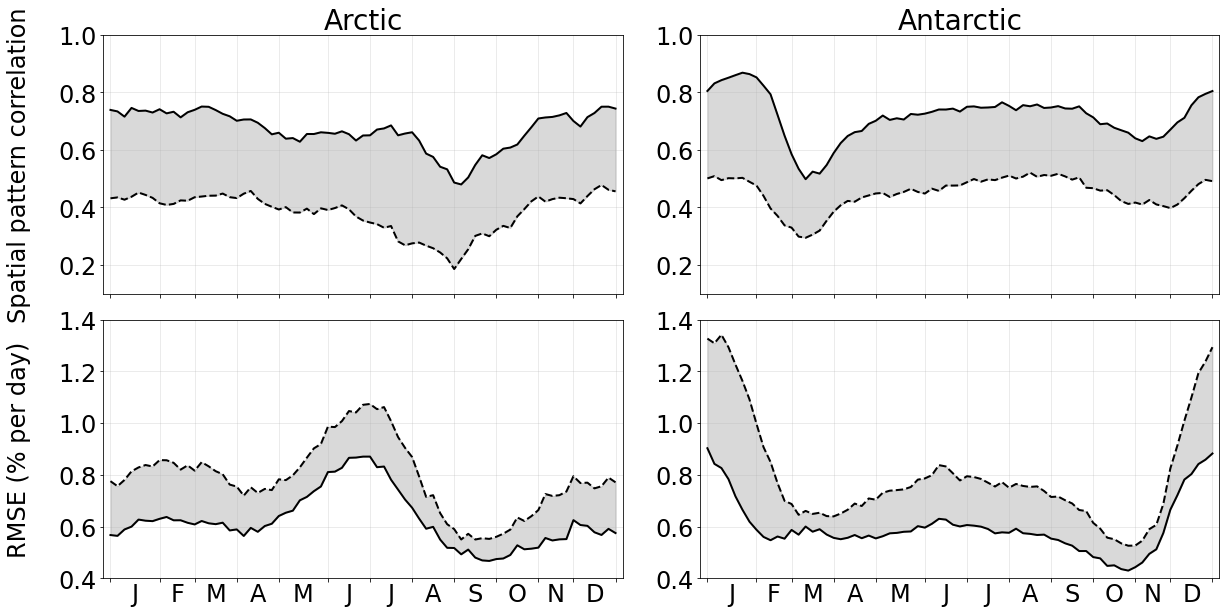

In [35]:
fig,ax = plt.subplots(2,2,sharex=True,figsize=(20,10))
labels = ['Spatial pattern correlation','RMSE (% per day)']
errorlims = [[0.1,1],[0.1,1],[.4,1.4],[.4,1.4]]
font = 24
k = 0
for ax1 in range(2):
    for ax2 in range(2):
        plot1 = get_climatology(clima_skill[k])
        plot2 = get_climatology(CNN_skill[k])
        ax[ax1,ax2].plot(plot1,color='k',lw=2,ls='--',label='Climatology prediction')
        ax[ax1,ax2].plot(plot2,color='k',lw=2)
        ax[ax1,ax2].fill_between(np.arange(73),y1=plot1,y2=plot2,alpha=0.15,color='k')

        ax[ax1,ax2].grid(True,alpha=0.3)
        if ax2 == 0:
            ax[ax1,ax2].set_ylabel(labels[ax1],labelpad=27,fontsize=24)

        month_names = ['J','F','M','A','M','J','J','A','S','O','N','D']
        month_starts = [0,7,12,18,24,31,37,43,49,55,61,66,72]
        month_mids = []
        for i in range(len(month_starts)-1):
            month_mids.append(np.mean([month_starts[i+1],month_starts[i]]))
        ax[ax1,ax2].set_xticks(month_starts,minor=False)
        ax[ax1,ax2].set_xticklabels('',minor=False)
        ax[ax1,ax2].set_xticks(month_mids,minor=True)
        ax[ax1,ax2].set_xticklabels(month_names,minor=True,fontsize=font)
        ax[ax1,ax2].tick_params(axis=u'x', which=u'minor',length=0)
        ax[ax1,ax2].tick_params(axis='both',labelsize=font,color='k',labelcolor='k')
        ax[ax1,ax2].set_xlim(-1,73)
        ax[ax1,ax2].set_ylim(errorlims[k]) 
        k += 1
ax[0,0].set_title('Arctic',fontsize=28)
ax[0,1].set_title('Antarctic',fontsize=28)
plt.subplots_adjust(hspace=0.1,wspace=0.15)
plt.show()